<a href="https://colab.research.google.com/github/lacykaltgr/continual-learning-ait/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#from google.colab import files
#files.download()

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

# Setup

In [3]:
#!mkdir clear-10
!mkdir clear-100
#!wget -O clear-10/train.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear10-train-image-only.zip
#!wget -O clear-10/test.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear10-test.zip
!wget -O clear-100/train.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear100-train-image-only.zip
!wget -O clear-100/test.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear100-test.zip

--2023-04-10 21:57:44--  https://clear-challenge.s3.us-east-2.amazonaws.com/clear100-train-image-only.zip
Resolving clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)... 52.219.178.50
Connecting to clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)|52.219.178.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3289951359 (3.1G) [application/zip]
Saving to: ‘clear-100/train.zip’

clear-100/train.zip 100%[===================>]   3.06G  29.6MB/s    in 1m 50s  

2023-04-10 21:59:35 (28.5 MB/s) - ‘clear-100/train.zip’ saved [3289951359/3289951359]

--2023-04-10 21:59:35--  https://clear-challenge.s3.us-east-2.amazonaws.com/clear100-test.zip
Resolving clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)... 52.219.105.242
Connecting to clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)|52.219.105.242|:443... connected.
HTTP 

In [4]:
#!unzip clear-10/train.zip -d clear-10/
#!unzip clear-10/test.zip -d clear-10/
!unzip clear-100/train.zip -d clear-100/
!unzip clear-100/test.zip -d clear-100/

Streaming output truncated to the last 5000 lines.
  inflating: clear-100/test/labeled_images/2/tie/3080182985.jpg  
  inflating: clear-100/test/labeled_images/2/tie/2970112507.jpg  
  inflating: clear-100/test/labeled_images/2/tie/2439024848.jpg  
  inflating: clear-100/test/labeled_images/2/tie/3049995617.jpg  
  inflating: clear-100/test/labeled_images/2/tie/2862317458.jpg  
  inflating: clear-100/test/labeled_images/2/tie/3048397454.jpg  
  inflating: clear-100/test/labeled_images/2/tie/2897339198.jpg  
  inflating: clear-100/test/labeled_images/2/tie/2959986121.jpg  
  inflating: clear-100/test/labeled_images/2/tie/2365250437.jpg  
   creating: clear-100/test/labeled_images/2/camera/
  inflating: clear-100/test/labeled_images/2/camera/2476436282.jpg  
  inflating: clear-100/test/labeled_images/2/camera/2687391265.jpg  
  inflating: clear-100/test/labeled_images/2/camera/2521637479.jpg  
  inflating: clear-100/test/labeled_images/2/camera/2645416338.jpg  
  inflating: clear-100/tes

In [5]:
import glob

#train_clear_10_image_paths = glob.glob("clear-10/train_image_only/labeled_images/*/*/*.jpg")
#test_clear_10_image_paths = glob.glob("clear-10/test/labeled_images/*/*/*.jpg")
train_clear_100_image_paths = glob.glob("clear-100/train_image_only/labeled_images/*/*/*.jpg")
test_clear_100_image_paths = glob.glob("clear-100/test/labeled_images/*/*/*.jpg")

#clear_10_features_path = "clear-10/test/class_names.txt"
clear_100_features_path = "clear-100/test/class_names.txt"

In [6]:
def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() 
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
  

def image_example(image_string, date, task):
  feature = {
      'date': _bytes_feature(date),
      'task': _bytes_feature(task),
      'image_raw': _bytes_feature(image_string),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

def write_to_tfrecord(image_paths, tfrecord_file_name):
  with tf.io.TFRecordWriter(f"{tfrecord_file_name}.tfrecord") as writer:
    for path in image_paths:
      date = path.split("/")[-3].encode()
      task = path.split("/")[-2].encode()
      with open(path, "rb") as image:
        image_string = image.read()
        tf_example = image_example(image_string, date, task)
        writer.write(tf_example.SerializeToString())

In [7]:
#write_to_tfrecord(train_clear_10_image_paths, 'train-clear-10')
#write_to_tfrecord(test_clear_10_image_paths, 'test-clear-10')
write_to_tfrecord(train_clear_100_image_paths, 'train-clear-100')
write_to_tfrecord(test_clear_100_image_paths, 'test-clear-100')

In [9]:
import shutil
shutil.copyfile('train-clear-100.tfrecord', '/content/gdrive/MyDrive/clear-dataset/train-clear-100.tfrecord')
shutil.copyfile('test-clear-100.tfrecord', '/content/gdrive/MyDrive/clear-dataset/test-clear-100.tfrecord')

'/content/gdrive/MyDrive/clear-dataset/test-clear-100.tfrecord'

In [10]:
shutil.copyfile('clear-100/train_image_only/class_names.txt', '/content/gdrive/MyDrive/clear-dataset/class-names-100.txt')

'/content/gdrive/MyDrive/clear-dataset/class-names-100.txt'

# CLeaR

In [ ]:
from tensorflow.keras.preprocessing.image import smart_resize
import tensorflow_datasets as tfds

IMAGE_SIZE = [256, 256]


def feature_encode_table(filepath):
    vocab = tf.io.read_file(filepath)
    vocab = tf.strings.split(vocab, sep="\n")
    vocab_size = tf.shape(vocab)[0]

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(vocab, tf.range(vocab_size)),
        default_value = -1
    )
    return table

def encode_task(task, feature_table):
    task_indices = feature_table.lookup(task)
    task_one_hot = tf.one_hot(task_indices, depth=int(feature_table.size()))
    return task_one_hot

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = smart_resize(image, IMAGE_SIZE)
    return image


def read_tfrecord_features(example, tfrecord_format):
    example = tf.io.parse_single_example(example, tfrecord_format)
    date = tf.strings.to_number(example['date'], out_type=tf.int32)
    image = decode_image(example['image_raw'])
    return (image, date)

def read_tfrecord_labels(example, feature_table, tfrecord_format):
    example = tf.io.parse_single_example(example, tfrecord_format)
    task = encode_task(example['task'], feature_table)
    return task


def load_dataset(record_filepath, feature_filepath):
    tfrecord_format = {
        "date": tf.io.FixedLenFeature([], tf.string),
        "task": tf.io.FixedLenFeature([], tf.string),
        "image_raw": tf.io.FixedLenFeature([], tf.string)
    }
    dataset = tf.data.TFRecordDataset(record_filepath)
    table = feature_encode_table(feature_filepath)
    X = dataset.map(lambda x: read_tfrecord_features(x, tfrecord_format))
    y = dataset.map(lambda x: read_tfrecord_labels(x, table, tfrecord_format))
    return (X, y)

In [ ]:
X_train_clear_10, y_train_clear_10 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)
X_test_clear_10, y_test_clear_10 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)
X_train_clear_100, y_train_clear_100 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)
X_test_clear_100, y_test_clear_100 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)

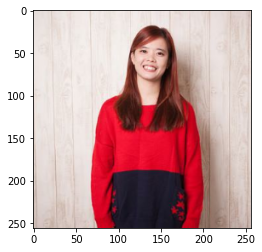

In [ ]:
import matplotlib.pyplot as plt

image = next(iter(X_train_clear_10))[0]
plt.imshow(image*0.5+0.5)
plt.show()

# CIFAR-100
Az eljárások adathalmazok közötti vizsgálatához.

In [ ]:
(X_train_cifar_100, y_train_cifar_100), (X_test_cifar_100, y_test_cifar_100) = tf.keras.datasets.cifar100.load_data()

In [ ]:
n_classes = 100
X_train_cifar_100 = (X_train_cifar_100 / 127.5) -1
X_test_cifar_100 = (X_test_cifar_100 / 127.5) -1
y_train_cifar_100 = tf.keras.utils.to_categorical(y_train_cifar_100, n_classes)
y_test_cifar_100 = tf.keras.utils.to_categorical(y_test_cifar_100, n_classes)

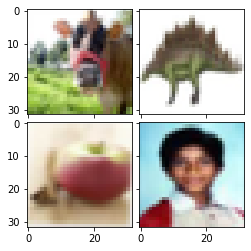

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1, )

for ax, i in zip(grid, range(4)):
    ax.imshow(X_train_cifar_100[i] * 0.5 + 0.5)